<a href="https://colab.research.google.com/github/ayushjain1144/NER/blob/master/NER_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [29]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook


# Loading the features and vocabulary

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s content/gdrive/My\ Drive/NER /ner_dir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/ner_dir/NER': Operation not supported


In [31]:
%cd ..
%cd /ner_dir


/content/gdrive/My Drive
/content/gdrive/My Drive/NER


In [32]:
!ls

activations.py			      params-1.npy
cal_statistics.py		      params-200.npy
Conll.ipynb			      params-250.npy
dataset				      params-2.npy
initial_experiment.ipynb	      params-300.npy
initialization.py		      params-50.npy
loss.py				      params-50-random_initialization.npy
NER_NN.ipynb			      params-50-range_initialization.npy
NER_NN_network.ipynb		      __pycache__
nn.py				      README.md
params-0.npy			      statistics.py
params-0-random_initialization.npy    test_features.npy
params-0-range_initialization.npy     train_features.npy
params-100.npy			      val_features.npy
params-100-random_initialization.npy  vocab.npy
params-100-range_initialization.npy   ytest.npy
params-150.npy			      ytrain.npy
params-150-range_initialization.npy   yval.npy


In [33]:
import activations
import loss
import initialization as init_layer

In [34]:
vocab = np.load('vocab.npy')
train_features = np.load('train_features.npy').T
test_features = np.load('test_features.npy').T
val_features = np.load('val_features.npy').T
y_train = np.load('ytrain.npy').T
y_val = np.load('yval.npy').T
y_test = np.load('ytest.npy').T

In [35]:
print(train_features.shape)
print(vocab.shape)
print(test_features.shape)
print(val_features.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(900, 204566)
(26872, 300)
(900, 46665)
(900, 51577)
(10, 204566)
(10, 46665)
(10, 51577)


In [36]:
train_features[:10]

array([[ 1.        , -0.92605459,  0.00982666, ...,  1.38121068,
         0.05078125,  1.46252757],
       [ 0.        , -1.13792351,  0.2265625 , ...,  0.8632994 ,
        -0.09326172, -0.07399186],
       [ 0.        , -0.7880129 ,  0.28125   , ...,  0.76144395,
         0.06494141,  0.03143081],
       ...,
       [ 0.        , -0.43820235, -0.03540039, ...,  0.7176954 ,
        -0.08154297,  0.11263644],
       [ 0.        , -0.95179252,  0.14746094, ...,  0.69231712,
         0.13085938,  0.80112245],
       [ 0.        , -1.45894089,  0.12890625, ..., -1.61798501,
         0.12597656, -0.11506672]])

In [37]:
y_train[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [38]:
C = 1
word_vector_dim = 300
num_tags = 10

# Neural Netwwork Architecture

In [39]:
nn_architecture = [
  {"layer_size": 900, "activation": "none"},
  {"layer_size": 300, "activation": "relu"},
  {"layer_size": 100, "activation": "relu"},
  {"layer_size": 10, "activation": "sigmoid"}
]

In [40]:
nn_architecture[1]['activation']

'relu'

# Initialize Parameters

In [41]:
def initialize_parameters(nn_architecture, initialization = "range_initialization", seed=5):

  parameters = {}
  num_layers = len(nn_architecture)

  for i in range(1, num_layers):

    if initialization == "range_initialization":
      parameters['W' + str(i)] = init_layer.range_initializtion(nn_architecture[i]["layer_size"],
                                            nn_architecture[i - 1]["layer_size"], seed)
    else:
      parameters['W' + str(i)] = init_layer.random_initialization(nn_architecture[i]["layer_size"],
                                            nn_architecture[i - 1]["layer_size"], seed)

    parameters['b' + str(i)] = np.zeros((nn_architecture[i]["layer_size"], 1))

  return parameters

In [42]:
param = initialize_parameters(nn_architecture, initialization="range_initialization")
for k in param.keys():
  print(f"{k}: {param[k].shape}")

W1: (300, 900)
b1: (300, 1)
W2: (100, 300)
b2: (100, 1)
W3: (10, 100)
b3: (10, 1)


# Forward Propogation

In [43]:
# Z = W * X + b
# Here A is output of previous layer

def linear_forward(A_prev, W, b):
  return np.dot(W, A_prev) + b

# apply activation h:  A = h(X) 
def apply_activation(A, activation, alpha=0.01):

  if activation == "sigmoid":
    return activations.sigmoid(A)
  elif activation == "tanh":
    return activations.tanh(A)
  elif activation == "relu":
    return activations.relu(A)
  elif activation == "leaky_relu":
    return activations.leaky_relu(A, alpha)
  elif activation == 'none':
    #print("None activation used")
    return A
  else:
    print(f"ERROR: {activation} activation not supported")
    sys.exit(1)
  
# driver forward propogation
def model_forward(X, parameters, nn_architecture, alpha=0.01):

  forward_cache = []
  A = X
  num_layers = len(nn_architecture)

  for i in range(1, num_layers):
    A_prev = A
    # print(f"{A_prev.shape}: for")
    W = parameters["W" + str(i)]
    b = parameters["b" + str(i)]

    Z = linear_forward(A_prev, W, b)
    activation = nn_architecture[i]['activation']
    # print(activation)
    A = apply_activation(Z, activation, alpha)
    # print(A)
    forward_cache.append(((A_prev, W, b), Z))

  # print("after loop")
  # print(A)
  return A, forward_cache  

# Backpropogation 

In [44]:
def linear_backward(dz, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  # print(m)
  dw = (1 / m) * np.dot(dz, A_prev.T)
  db = (1 / m) * np.sum(dz, axis=1, keepdims=True)
  dA_prev = np.dot(W.T, dz)

  assert dA_prev.shape == A_prev.shape
  assert dw.shape == W.shape
  assert db.shape == b.shape

  return dA_prev, dw, db      

In [45]:
def apply_activation_backward(dA, cache, activation_fn):
  linear_cache, activation_cache = cache

  if activation_fn == "sigmoid":
    dZ = activations.sigmoid_backward(dA, activation_cache)
    dA_prev, dw, db = linear_backward(dZ, linear_cache)

  elif activation_fn == "tanh":
    dZ = activations.tanh_backward(dA, activation_cache)
    dA_prev, dw, db = linear_backward(dZ, linear_cache)

  elif activation_fn == "relu":
    dZ = activations.relu_backward(dA, activation_cache)
    dA_prev, dw, db = linear_backward(dZ, linear_cache)

  elif activation_fn == "leaky_relu":
    dZ = activations.leaky_relu_backward(dA, activation_cache)
    dA_prev, dw, db = linear_backward(dZ, linear_cache)
  
  elif activation_fn == "none":
    dZ = dA
    dA_prev, dw, db = linear_backward(dZ, linear_cache)
  
  else:
    print("Activation not available")
    sys.exit(1)

  return dA_prev, dw, db

  


In [46]:
def model_backward(AL, y, caches, nn_architecture):
  
  y = y.reshape(AL.shape)
  L = len(caches)
  # print(f"Len of cache: {len(caches)}")
  grads = {}

  dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))
  # print(caches.keys())
  # print(grads.keys())
  # print(len(caches))
  grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = apply_activation_backward(dAL, caches[L-1], nn_architecture[L]['activation'])

  for l in range(L - 1, 0, -1):
    # print(l)
    current_cache = caches[l - 1]
    grads["dA" + str(l - 1)], grads["dW" + str(l)],  \
        grads["db" + str(l)] = apply_activation_backward(
            grads["dA" + str(l)], current_cache, 
            nn_architecture[l]['activation']
        )
    
  return grads

In [47]:
def update_parameters(parameters, grads, lr):

  L = len(parameters) // 2

  for l in range(1, L + 1):
    parameters["W" + str(l)] = parameters["W" + str(l)] - \
            lr * grads["dW" + str(l)]
    parameters["b" + str(l)] = parameters["b" + str(l)] - \
            lr * grads["db" + str(l)]
  return parameters

In [48]:
def model(X, y, nn_architecture, initialization='range_initialisation', lr=0.01, num_iterations=2000, print_cost=True, checkpoint_initialisation=None):

  np.random.seed(1)

  if checkpoint_initialisation == None:
    parameters = initialize_parameters(nn_architecture, initialization)
  else:
    print(f"Loading checkpoints from file {checkpoint_initialisation}")
    parameters = np.load(checkpoint_initialisation, allow_pickle=True).item()

  cost_list = []
  val_list = []
  #iterate over iterations

  for i in tqdm_notebook(range(0, num_iterations)):

    #forward step
    AL, caches = model_forward(X, parameters, nn_architecture)

    cost = loss.cross_entropy_loss(AL, y)
    # print(cost)
    grads = model_backward(AL, y, caches, nn_architecture)

    parameters = update_parameters(parameters, grads, lr)

    if (i + 1) % 10 == 0 and print_cost:
      print(f"The cost after {i + 1} iterations is: {cost: .4f}")
      acc = accuracy(val_features, parameters, y_val, nn_architecture)
      print(f"The val accuracy after {i + 1} iterations is: {acc}")
      val_list.append(acc)

    if i % 10 == 0:
      cost_list.append(cost)

    if i % 50 == 0:
      print(f"Creating checkpoint for {i}th iteration")
      np.save(f'params-{i}-{initialization}.npy', parameters)

    #plotting cost curve

  plt.figure(figsize=(10, 6))
  plt.plot(cost_list)
  plt.xlabel("Iterations (per 50)")
  plt.ylabel("Loss")
  plt.title(f"Loss curve for the learning rate = {lr}")

  plt.figure(figsize=(10, 6))
  plt.plot(val_list)
  plt.xlabel("Iterations (per 50)")
  plt.ylabel("Val Accuracy")
  plt.title(f"Val Accuracy curve for the learning rate = {lr}")

  return parameters

In [49]:
def accuracy(X, parameters, y, nn_architecture):
  probs, caches = model_forward(X, parameters, nn_architecture)
  labels = (probs >= 0.5) * 1
  accuracy = np.mean(labels == y) * 100

  return f"The accuracy rate is {accuracy: .2f}%."

In [50]:
# params = model(train_features, y_train, nn_architecture, initialization='range_initialization', lr=0.01, num_iterations=300)

# accuracy(test_features, params, y_test, nn_architecture)


In [51]:
# Todo

#implement margin loss
#implement regularisation

# Gradient Checking

In [52]:
from numpy.linalg import norm

def dictionary_to_vector(params_dict):
  count = 0

  for key in params_dict.keys():
    new_vector = np.reshape(params_dict[key], (-1, 1))

    if count == 0:
      theta_vector = new_vector
    else:
      theta_vector = np.concatenate((theta_vector, new_vector))
    count += 1

  return theta_vector



In [53]:
def vector_to_dictionary(vector, nn_architecture):

  L = len(nn_architecture)
  parameters = {}
  k = 0

  for l in range(1, L):

    w_dim = nn_architecture[l]['layer_size'] * nn_architecture[l - 1]['layer_size']
    b_dim = nn_architecture[l]['layer_size']

    temp_dim = k + w_dim

    parameters["W" + str(l)] = vector[k:temp_dim].reshape(nn_architecture[l]['layer_size'], nn_architecture[l - 1]['layer_size'])
    parameters["b" + str(l)] = vector[temp_dim:temp_dim + b_dim].reshape(b_dim, 1)

    k += w_dim + b_dim

  return parameters

In [54]:
def gradients_to_vector(gradients):

  valid_grads = [key for key in gradients.keys() if not key.startswith("dA")]
  L = len(valid_grads) // 2

  count = 0

  for l in range(1, L + 1):
    if count == 0:
      new_grads = gradients["dW" + str(l)].reshape(-1, 1)
      new_grads = np.concatenate((new_grads, gradients["db" + str(l)].reshape(-1, 1)))

    else:
      new_grads = np.concatenate((new_grads, gradients["dW" + str(l)].reshape(-1, 1)))
      new_grads = np.concatenate((new_grads, gradients["db" + str(l)].reshape(-1, 1)))

    count += 1
  return new_grads

In [55]:
def forward_prop_cost(X, parameters, Y, nn_architecture):

  AL, _ = model_forward(X, parameters, nn_architecture)
  cost = loss.cross_entropy_loss(AL, Y)
  # print(cost)
  return cost

def gradient_check(parameters, gradients, X, Y, nn_architecture, epsilon=1e-4):

  parameters_vector = dictionary_to_vector(parameters)
  gradients_vector = gradients_to_vector(gradients)

  grads_approx = np.zeros_like(parameters_vector)

  for i in range(len(parameters_vector)):

    theta_plus = np.copy(parameters_vector)
    theta_plus[i] = theta_plus[i] + epsilon
    j_plus = forward_prop_cost(X, vector_to_dictionary(theta_plus, nn_architecture), Y, nn_architecture)


    theta_minus = np.copy(parameters_vector)
    theta_minus[i] = theta_minus[i] - epsilon
    j_minus = forward_prop_cost(X, vector_to_dictionary(theta_minus, nn_architecture), Y, nn_architecture)

    grads_approx[i] = (j_plus - j_minus) / (2 * epsilon)

    #print(f"grads_approx{i}: {grads_approx[i]} and {gradients_vector[i]}")

  

  numerator = norm(gradients_vector - grads_approx)
  denominator = norm(grads_approx) + norm(gradients_vector)

  difference = numerator / denominator

  if difference > 10e-4:
    print(f"Backprop Wrong: difference = {difference}")
  else:
    print(f"Backprop Correct: difference = {difference}")

  return difference





### Execute the following cell for gradient checking. 

In [56]:
# performing graident checking

parameters = initialize_parameters(nn_architecture)

perms = np.random.permutation(train_features.shape[1])
index = perms[:1]
print(train_features[:, index].shape)
print(y_train[:, index].shape)

AL, caches = model_forward(train_features[:, index], parameters, nn_architecture)
grads = model_backward(AL, y_train[:, index], caches, nn_architecture)
#print(grads)
difference = gradient_check(parameters, grads, train_features[:, index], y_train[:, index], nn_architecture)



(900, 1)
(10, 1)
2
1
Backprop Correct: difference = 8.085386956443845e-11


### Execute the following cell for training the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


2
1
Creating checkpoint for 0th iteration
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
The cost after 10 iterations is:  3.7674
The val accuracy after 10 iterations is: The accuracy rate is  95.80%.
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
The cost after 20 iterations is:  2.7806
The val accuracy after 20 iterations is: The accuracy rate is  96.41%.
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
The cost after 30 iterations is:  2.4083
The val accuracy after 30 iterations is: The accuracy rate is  96.42%.
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
The cost after 40 iterations is:  2.2132
The val accuracy after 40 iterations is: The accuracy rate is  96.42%.
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
The cost after 50 iterations is:  2.0857
The val accuracy after 50 iterations is: The accuracy rate is  96.43%.
2
1
Creating checkpoint for 50th iteration
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
The cost after 60 iterations is:  1.9905
The val accuracy after 60 iterations is: The accuracy rate is  96.43%.
2
1
2
1
2
1

'The accuracy rate is  96.42%.'

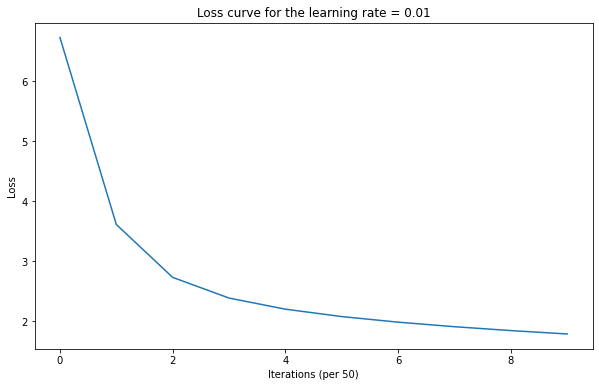

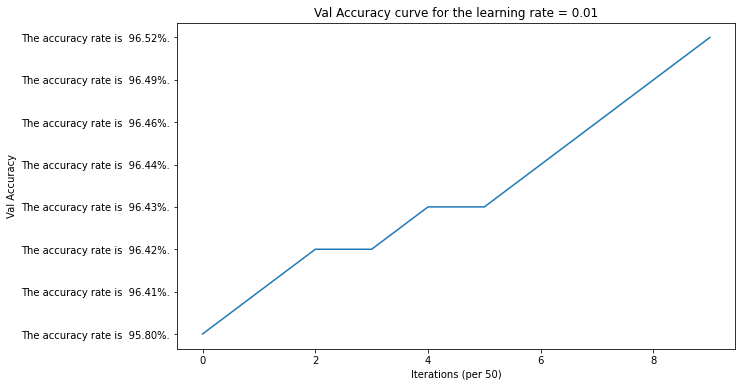

In [57]:
params = model(train_features, y_train, nn_architecture, initialization='range_initialization', lr=0.01, num_iterations=100)

accuracy(test_features, params, y_test, nn_architecture)